In [1]:
from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


In [2]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt
print('슝=3')

슝=3


## Step 1. 인물모드 직접 해 보기

 (1) 사진을 준비하자

(3216, 1448, 3)


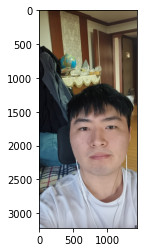

In [3]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/그림1.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f8c240f2730>)

In [5]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [6]:
segvalues, output = model.segmentAsPascalvoc(img_path)

In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [8]:
output.shape

(1448, 3216, 3)

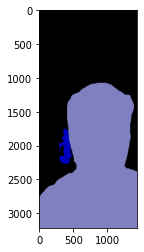

In [9]:
output = output.swapaxes(0,1)
output = cv2.flip(output, 0)
plt.imshow(output)
plt.show()

In [10]:
segvalues

{'class_ids': array([ 0,  9, 15]),
 'masks': array([[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])}

In [11]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person


In [12]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

PixelLib에 따르면 위와 같은 색을 사용했다고 하네요. 그럼 사람을 나타내는 15번째 색상은 무엇일까요?

In [13]:
colormap[15]

array([192, 128, 128])

In [14]:
seg_color = (128,128,192)

(3216, 1448)


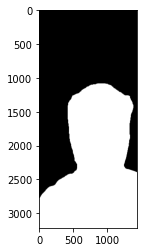

In [15]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

원래 이미지와 겹쳐 보기

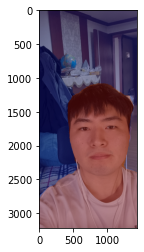

In [16]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

이번에는 배경을 흐리게 만듭니다. blur() 함수를 이용합니다.

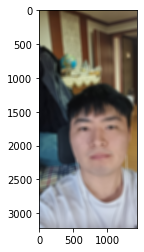

In [17]:
img_orig_blur = cv2.blur(img_orig, (50,50))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

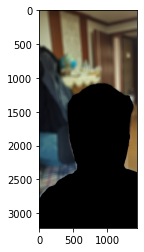

In [18]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

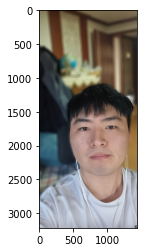

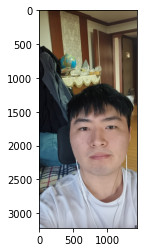

In [19]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

원본과 잘 합성이 잘 되었다.

(1376, 1920, 3)


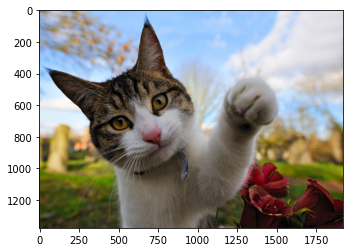

In [20]:
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/고양이.jpg'  
img_orig2 = cv2.imread(img_path2) 

print(img_orig2.shape)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.show()

In [21]:
segvalues2, output2 = model.segmentAsPascalvoc(img_path2)

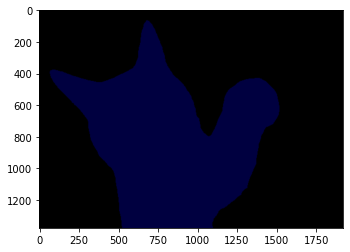

In [22]:
plt.imshow(output2)
plt.show()

In [23]:
segvalues2

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [24]:
for class_id in segvalues2['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


In [25]:
colormap[8]

array([64,  0,  0])

In [26]:
seg_color2 = (0,0,64)

(1376, 1920)


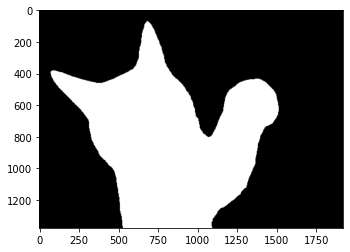

In [27]:
# output2의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map2 = np.all(output2==seg_color2, axis=-1)
print(seg_map2.shape)
plt.imshow(seg_map2, cmap='gray')
plt.show()

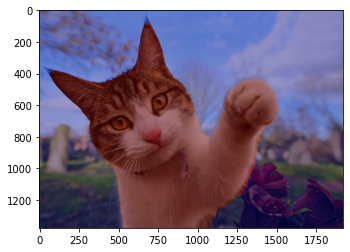

In [28]:
img_show = img_orig2.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map2.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

이번에는 배경을 흐리게 만듭니다. blur() 함수를 이용합니다.

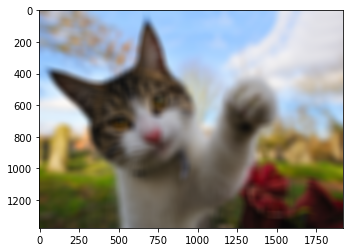

In [29]:
img_orig_blur = cv2.blur(img_orig2, (50,50))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

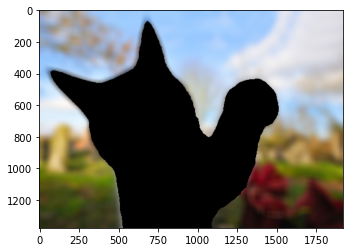

In [30]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

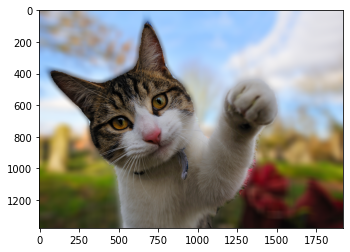

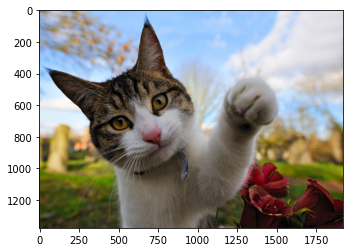

In [31]:
img_concat = np.where(img_mask_color==255, img_orig2, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.show()

배경이 뿌옇게 잘 처리 되었다.

이번에는 다른 배경을 가져와서 처음의 내 사진을 위에 덮어 쓸 것이다. 

(3216, 1448, 3)


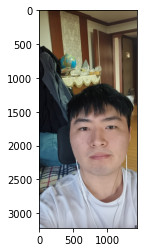

In [32]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/그림1.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

(3216, 1448)


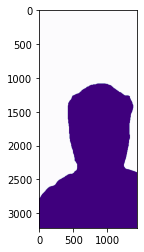

In [42]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='Purples')
plt.show()

(4032, 1816, 3)


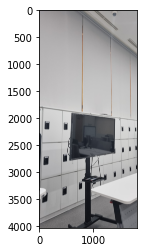

In [34]:
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/배경.jpg'  
img_orig3 = cv2.imread(img_path3) 

print(img_orig3.shape)
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.show()

먼저 이미지 크기를 조정해준다. 

In [35]:
resize_img3 = cv2.resize(img_orig3, (1448, 3216))

(3216, 1448, 3)


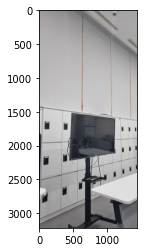

In [36]:
print(resize_img3.shape)
plt.imshow(cv2.cvtColor(resize_img3, cv2.COLOR_BGR2RGB))
plt.show()

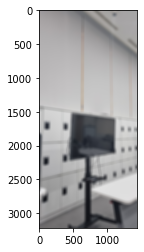

In [37]:
resize_img3_blur = cv2.blur(resize_img3, (50,50))  
plt.imshow(cv2.cvtColor(resize_img3_blur, cv2.COLOR_BGR2RGB))
plt.show()

In [38]:
img_orig.shape

(3216, 1448, 3)

In [43]:
img_show = img_orig.copy()

In [44]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

In [59]:
save_path = os.getenv('HOME')+'/aiffel/human_segmentation/images'

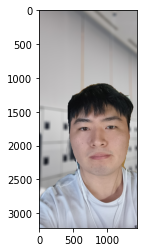

In [62]:
img_concat = np.where(img_mask_color==255, img_orig, resize_img3_blur)
# 마스크된 이미지 색깔이 일치하는것 + 마스크된 이미지 원본 + 배경
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

배경전환 크로마키 사진까지 잘 완료되었다.

## Step 2. 사진에서 문제점 찾기

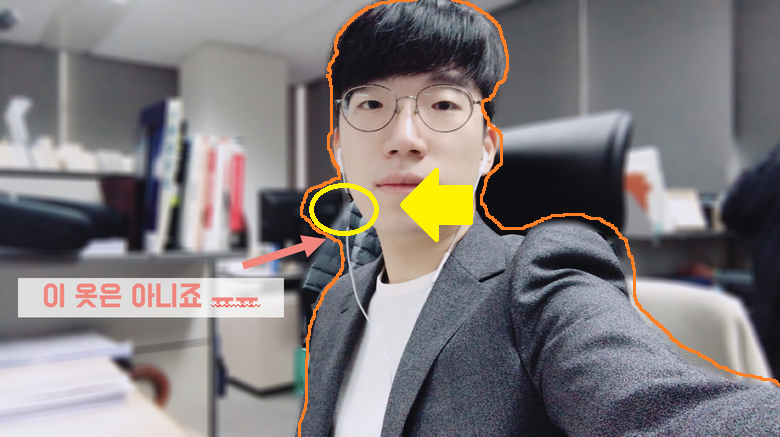

이 사진의 문제점은 

1. 옷은 blur 처리가 안되었고
2. 이어폰 같이 얇은 착용물은 중간에 배경처리로 넘어가 버려서 뿌옇게 표시가 된다.
3. 사람과 배경사이의 경계 부분이 매끄럽게 구분이 되지 않고 흐릿하게 보인다.

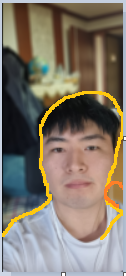

내가 만든 인물사진도 경계부분과 이어폰은 조금 소실되었다.

## Step 3. 해결 방법을 제안해 보기


Semantic segmentation의 문제점은 사진을 2D 즉 2차원에서 받아드리는 점에서 생긴다. 문제가 생긴 사진에서 옷이 나오는 이유는 무엇일까?
그건 사람이 입고 있는 옷으로 모델이 착각을 했기 때문이다. 요새는 거리를 인식하는 3D이미지 센서가 개발되었다고 한다. 거리를 인식한다면
뒤에 걸린 옷은 멀리있기 때문에 사람이 입고있지 않은 것으로 인식을 할 수 있을 것이다. depth도 동적 자료를 바탕으로 깊이를 예측하는 것을 보아

꼭 3D 이미지 센서가 아니더라도  파노라마 사진이나 동영상같이 여러 각도의 정보를 가질 수 있는 이미지가 있다면 더욱 배경과 인물을 잘 구별할 수 있을 것이라고 생각한다.